In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/SRFP/DPIR

/content/drive/MyDrive/SRFP/DPIR


In [ ]:
!ls 

DPIR_deblur.ipynb		       main_dpir_demosaick.py
DPIR_deblur_restomer_FineTuning.ipynb  main_dpir_denoising.py
DPIR_Denoising_drunet_color.ipynb      main_dpir_sisr.py
DPIR_sigma15_Denoising_Restomer.ipynb  main_dpir_sisr_real_applications.py
figs				       models
kernels				       model_zoo
LICENSE				       README.md
main_download_pretrained_models.py     results
main_dpir_deblocking_color.py	       testsets
main_dpir_deblocking_grayscale.py      utils
main_dpir_deblur.py


In [ ]:
!pip install einops
!pip install hdf5storage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.0 MB/s 


In [ ]:

# -*- coding: utf-8 -*-
import numpy as np


'''
modified by Kai Zhang (github: https://github.com/cszn)
03/03/2019
'''


# --------------------------------
# get rho and sigma
# --------------------------------
#def get_rho_sigma(sigma=2.55/255, iter_num=15, modelSigma1=49.0, modelSigma2=2.55):
#    '''
#    One can change the sigma to implicitly change the trade-off parameter
#    between fidelity term and prior term
#    '''
#    modelSigmaS = np.logspace(np.log10(modelSigma1), np.log10(modelSigma2), iter_num).astype(np.float32)
#    sigmas = modelSigmaS/255.
#    rhos = list(map(lambda x: 0.23*(sigma**2)/(x**2), sigmas))
#    return rhos, sigmas

# --------------------------------
# get rho and sigma
# --------------------------------
def get_rho_sigma(sigma=2.55/255, iter_num=15, modelSigma1=49.0, modelSigma2=2.55, w=1.0,Lam = 0.23): #rhos, sigmas = pnp.get_rho_sigma(sigma=max(0.255/255., noise_level_model), iter_num=iter_num, modelSigma1=modelSigma1, modelSigma2=modelSigma2, w=1.0)
    '''
    One can change the sigma to implicitly change the trade-off parameter
    between fidelity term and prior term
    '''
    modelSigmaS = np.logspace(np.log10(modelSigma1), np.log10(modelSigma2), iter_num).astype(np.float32)
    modelSigmaS_lin = np.linspace(modelSigma1, modelSigma2, iter_num).astype(np.float32) 
    sigmas = (modelSigmaS*w+modelSigmaS_lin*(1-w))/255.        
    rhos = list(map(lambda x: Lam*(sigma**2)/(x**2), sigmas)) # it was list(map(lambda x: 0.23*(sigma**2)/(x**2), sigmas)) sifm
    # sigmas = np.ones(8)*15./255.
    # rhos  = [0.02342773760162471, 0.039826191994044274, 0.06770290338800085, 0.11509216853581325, 0.19565196624038125, 0.3326003515694873, 0.5654070160198102, 0.9611687048511582] #= lambdas
    return rhos, sigmas


def get_rho_sigma1(sigma=2.55/255, iter_num=15, modelSigma1=49.0, modelSigma2=2.55, lamda=3.0):
    '''
    One can change the sigma to implicitly change the trade-off parameter
    between fidelity term and prior term
    '''
    #modelSigmaS = np.logspace(np.log10(modelSigma1), np.log10(modelSigma2), iter_num).astype(np.float32)
    #sigmas = modelSigmaS/255.
    sigmas = np.ones(8)*15./255.
    rhos  = [0.02342773760162471, 0.039826191994044274, 0.06770290338800085, 0.11509216853581325, 0.19565196624038125, 0.3326003515694873, 0.5654070160198102, 0.9611687048511582] #= lambdas
    #rhos = list(map(lambda x: 0.23*(sigma**2)/(x**2), sigmas))
    return rhos, sigmas


#if __name__ == '__main__':
   # rhos, sigmas = get_rho_sigma(sigma=2.55/255, iter_num=5, modelSigma2=2.55)



In [ ]:
rhos, sigmas = get_rho_sigma(sigma=max(0.255/255., 1.3), iter_num=8, modelSigma1=49, modelSigma2= 1.3*255, w=1.0) #chucked the pnp.get_rho_sigma
print(rhos)
print(sigmas*255)


[10.526954016248762, 6.096460144817678, 3.5306345702662147, 2.044691581607669, 1.1841392358096412, 0.6857689710548769, 0.3971483908820566, 0.23000001687270039]
[ 49.       64.38854  84.60988 111.18176 146.0986  191.98112 252.27316
 331.5    ]


In [ ]:
import os.path
import cv2
import logging

import numpy as np
from datetime import datetime
from collections import OrderedDict
import hdf5storage
from scipy import ndimage

import torch

from utils import utils_deblur
from utils import utils_logger
from utils import utils_model
#from utils import utils_pnp as pnp
from utils import utils_sisr as sr
from utils import utils_image as util

from runpy import run_path


"""
Spyder (Python 3.7)
PyTorch 1.6.0
Windows 10 or Linux
Kai Zhang (cskaizhang@gmail.com)
github: https://github.com/cszn/DPIR
        https://github.com/cszn/IRCNN
        https://github.com/cszn/KAIR
@article{zhang2020plug,
  title={Plug-and-Play Image Restoration with Deep Denoiser Prior},
  author={Zhang, Kai and Li, Yawei and Zuo, Wangmeng and Zhang, Lei and Van Gool, Luc and Timofte, Radu},
  journal={arXiv preprint},
  year={2020}
}
% If you have any question, please feel free to contact with me.
% Kai Zhang (e-mail: cskaizhang@gmail.com; homepage: https://cszn.github.io/)
by Kai Zhang (01/August/2020)

# --------------------------------------------
|--model_zoo               # model_zoo
   |--drunet_gray          # model_name, for color images
   |--drunet_color
|--testset                 # testsets
|--results                 # results
# --------------------------------------------
"""

# def main():
def iterate_hyper_params(_lam_,NLM=1.5):
  # ----------------------------------------
  # Preparation
  # ----------------------------------------

  noise_level_img = 7.65/255.0         # default: 0, noise level for LR image
  noise_level_model = NLM #noise_level_img #noise_level_img  # noise level of model, default 0
  model_name ='gaussian_color_denoising_blind' #'gaussian_color_denoising_blind'#'real_denoising' #'gaussian_color_denoising_sigma15'#'gaussian_color_denoising_sigma15'   #'drunet_color' #'drunet_gray'           # 'drunet_gray' | 'drunet_color' | 'ircnn_gray' | 'ircnn_color'
  testset_name = 'set3c'               # test set,  'set5' | 'srbsd68'
  x8 = True                            # default: False, x8 to boost performance
  iter_num = 8                        # number of iterations
  modelSigma1 = 49
  modelSigma2 = noise_level_model*255.
  lam=_lam_

  show_img = True                     # default: False
  save_L = True                        # save LR image
  save_E = True                        # save estimated image
  save_LEH = True                     # save zoomed LR, E and H images
  save_lr = True
  border = 0

  # --------------------------------
  # load kernel
  # --------------------------------

  kernels = hdf5storage.loadmat(os.path.join('kernels', 'Levin09.mat'))['kernels'] #numpy array of shape (1,8) ; contains kernals of shape 17x17

  sf = 1
  task_current = 'deblur'              # 'deblur' for deblurring
  n_channels = 3 #if 'color' in  model_name else 1  # fixed
  model_zoo = 'model_zoo'              # fixed
  testsets = 'testsets'                # fixed
  results = 'results'                  # fixed
  result_name = testset_name + '_' + task_current + '_' + model_name   #Set3C_deblur_drunet_color
  model_path = os.path.join(model_zoo, model_name+'.pth')              #model_zoo/drunet_color.pth
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  torch.cuda.empty_cache()

  # ----------------------------------------
  # L_path, E_path, H_path
  # ----------------------------------------

  L_path = os.path.join(testsets, testset_name) # L_path, for Low-quality images testsets/Set3C
  E_path = os.path.join(results, result_name)   # E_path, for Estimated images  results/Set3C_deblur_drunet_color
  util.mkdir(E_path)

  logger_name = result_name
  utils_logger.logger_info(logger_name, log_path=os.path.join(E_path, logger_name+'.log'))
  logger = logging.getLogger(logger_name)

  # ----------------------------------------
  # load model
  # ----------------------------------------

  if 'drunet' in model_name:
      from models.network_unet import UNetRes as net
      model = net(in_nc=n_channels+1, out_nc=n_channels, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
      model.load_state_dict(torch.load(model_path), strict=True)
      model.eval()
      for _, v in model.named_parameters():
          v.requires_grad = False
      model = model.to(device)
  elif 'ircnn' in model_name:
      from models.network_dncnn import IRCNN as net
      model = net(in_nc=n_channels, out_nc=n_channels, nc=64)
      model25 = torch.load(model_path)
      former_idx = 0
  elif 'denoising' in model_name:
      parameters = {'inp_channels':3, 'out_channels':3, 'dim':48, 'num_blocks':[4,6,6,8], 'num_refinement_blocks':4, 'heads':[1,2,4,8], 'ffn_expansion_factor':2.66, 'bias':False, 'LayerNorm_type':'BiasFree', 'dual_pixel_task':False}
      load_arch = run_path(os.path.join('models', 'restormer_arch.py'))
      model = load_arch['Restormer'](**parameters)
      checkpoint = torch.load(model_path)
      model.load_state_dict(checkpoint['params'], strict=True)
      #model.load_state_dict(torch.load(model_path), strict=True) #load the weights of the network
      model.eval()# set to training mode
      for k, v in model.named_parameters():
          v.requires_grad = False
      model = model.to(device)
      

  logger.info('model_name:{}, image sigma:{:.3f}, model sigma:{:.3f}'.format(model_name, noise_level_img, noise_level_model))
  logger.info('Model path: {:s}'.format(model_path))
  logger.info(L_path)
  L_paths = util.get_image_paths(L_path)

  test_results_ave = OrderedDict()
  test_results_ave['psnr'] = []  # record average PSNR for each kernel

  for k_index in range(kernels.shape[1]): #so that we only use one kernal now

      logger.info('-------k:{:>2d} ---------'.format(k_index))
      test_results = OrderedDict()
      test_results['psnr'] = []
      average_of_all_kernals = []
      k = kernels[0, k_index].astype(np.float64)
      util.imshow(k) if show_img else None

      for idx, img in enumerate(L_paths):

          # --------------------------------
          # (1) get img_L
          # --------------------------------

          img_name, ext = os.path.splitext(os.path.basename(img))
          img_H = util.imread_uint(img, n_channels=n_channels) #img_H: read the image using cv2
          img_H = util.modcrop(img_H, 8)  # modcrop:crop the image H and W to be a multiple of 8

          img_L = ndimage.filters.convolve(img_H, np.expand_dims(k, axis=2), mode='wrap') #the images is blurred using the kernal and then add noise
          #util.imshow(img_L) if show_img else None
          util.imsave(img_L, os.path.join(E_path, img_name+'_k'+str(k_index)+'_'+model_name+'LR.png')) if save_lr else None
          img_L = util.uint2single(img_L)# just divided by 255 and made dtype int-> float32

          np.random.seed(seed=0)  # for reproducibility
          img_L += np.random.normal(0, noise_level_img, img_L.shape) # add AWGN

          # --------------------------------
          # (2) get rhos and sigmas
          # --------------------------------
          # sigmas = np.ones(iter_num)*15./255.
          # rhos = list(map(lambda x: 0.23*(noise_level_model**2)/(x**2), sigmas))
          rhos, sigmas = get_rho_sigma(sigma=max(0.255/255., noise_level_model), iter_num=iter_num, modelSigma1=modelSigma1, modelSigma2=modelSigma2, w=1.0, Lam = lam) #chucked the pnp.get_rho_sigma
          rhos, sigmas = torch.tensor(rhos).to(device), torch.tensor(sigmas).to(device)

          # --------------------------------
          # (3) initialize x, and pre-calculation
          # --------------------------------

          x = util.single2tensor4(img_L).to(device)

          img_L_tensor, k_tensor = util.single2tensor4(img_L), util.single2tensor4(np.expand_dims(k, 2))
          [k_tensor, img_L_tensor] = util.todevice([k_tensor, img_L_tensor], device)
          FB, FBC, F2B, FBFy = sr.pre_calculate(img_L_tensor, k_tensor, sf)

          # --------------------------------
          # (4) main iterations
          # --------------------------------

          for i in range(iter_num):

              # --------------------------------
              # step 1, FFT
              # --------------------------------

              tau = rhos[i].float().repeat(1, 1, 1, 1)
              x = sr.data_solution(x, FB, FBC, F2B, FBFy, tau, sf)

              if 'ircnn' in model_name:
                  current_idx = np.int(np.ceil(sigmas[i].cpu().numpy()*255./2.)-1)
      
                  if current_idx != former_idx:
                      model.load_state_dict(model25[str(current_idx)], strict=True)
                      model.eval()
                      for _, v in model.named_parameters():
                          v.requires_grad = False
                      model = model.to(device)
                  former_idx = current_idx

              # --------------------------------
              # step 2, denoiser
              # --------------------------------

              if x8:
                  x = util.augment_img_tensor4(x, i % 8)# rotates the image depending upon i%8

              if 'drunet'  in model_name:
                  x = torch.cat((x, sigmas[i].float().repeat(1, 1, x.shape[2], x.shape[3])), dim=1)
                  x = utils_model.test_mode(model, x, mode=2, refield=32, min_size=256, modulo=16)
              elif 'ircnn' in  model_name:
                  x = model(x)
              elif 'denoising'  in model_name:
                 # x = utils_model.test_mode(model, x, mode=2, refield=32, min_size=256, modulo=16)
                  x = model(x) #with boost it took 35 seaconds extra and gave lesser results of 0.08db
                

                 

              if x8:
                  if i % 8 == 3 or i % 8 == 5:
                      x = util.augment_img_tensor4(x, 8 - i % 8)
                  else:
                      x = util.augment_img_tensor4(x, i % 8)

          # --------------------------------
          # (3) img_E
          # --------------------------------

          img_E = util.tensor2uint(x)
          if n_channels == 1:
              img_H = img_H.squeeze()

          if save_E:
              util.imsave(img_E, os.path.join(E_path, img_name+'_k'+str(k_index)+'_'+model_name+'.png'))

          # --------------------------------
          # (4) img_LEH
          # --------------------------------

          if save_LEH:
              img_L = util.single2uint(img_L)
              k_v = k/np.max(k)*1.0
              k_v = util.single2uint(np.tile(k_v[..., np.newaxis], [1, 1, 3]))
              k_v = cv2.resize(k_v, (3*k_v.shape[1], 3*k_v.shape[0]), interpolation=cv2.INTER_NEAREST)
              img_I = cv2.resize(img_L, (sf*img_L.shape[1], sf*img_L.shape[0]), interpolation=cv2.INTER_NEAREST)
              img_I[:k_v.shape[0], -k_v.shape[1]:, :] = k_v
              img_I[:img_L.shape[0], :img_L.shape[1], :] = img_L
              util.imshow(np.concatenate([img_I, img_E, img_H], axis=1), title='LR / Recovered / Ground-truth') if show_img else None
              util.imsave(np.concatenate([img_I, img_E, img_H], axis=1), os.path.join(E_path, img_name+'_k'+str(k_index)+'_LEH.png'))

          if save_L:
              util.imsave(util.single2uint(img_L), os.path.join(E_path, img_name+'_k'+str(k_index)+'_LR.png'))

          psnr = util.calculate_psnr(img_E, img_H, border=border)  # change with your own border
          test_results['psnr'].append(psnr)
          logger.info('{:->4d}--> {:>10s} --k:{:>2d} PSNR: {:.2f}dB'.format(idx+1, img_name+ext, k_index, psnr))


      # --------------------------------
      # Average PSNR
      # --------------------------------

      ave_psnr = sum(test_results['psnr']) / len(test_results['psnr'])
      logger.info('------> Average PSNR of ({}), kernel: ({}) sigma: ({:.2f}): {:.2f} dB'.format(testset_name, k_index, noise_level_model, ave_psnr))
      test_results_ave['psnr'].append(ave_psnr)
  print('Average of all kernels :',np.sum(np.asarray(test_results_ave['psnr']))/len(test_results_ave['psnr']),'Lamda:',lam,'Sigma2: ',NLM)
  return np.sum(np.asarray(test_results_ave['psnr']))/len(test_results_ave['psnr'])

# if __name__ == '__main__':

#     main()


LogHandlers exists!


22-06-27 10:43:08.772 : model_name:gaussian_color_denoising_blind, image sigma:0.030, model sigma:1.300
22-06-27 10:43:08.774 : Model path: model_zoo/gaussian_color_denoising_blind.pth
22-06-27 10:43:08.778 : testsets/set3c
22-06-27 10:43:08.785 : -------k: 0 ---------


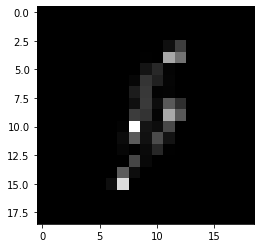

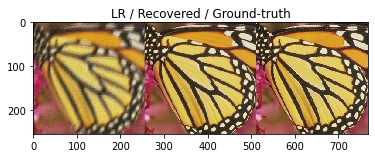

22-06-27 10:43:12.706 : ---1--> butterfly.png --k: 0 PSNR: 28.91dB


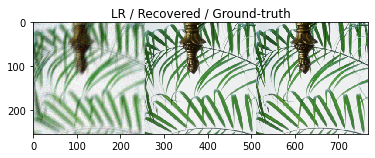

22-06-27 10:43:16.449 : ---2--> leaves.png --k: 0 PSNR: 29.51dB


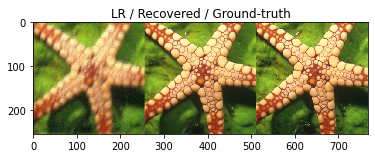

22-06-27 10:43:20.080 : ---3--> starfish.png --k: 0 PSNR: 29.41dB
22-06-27 10:43:20.085 : ------> Average PSNR of (set3c), kernel: (0) sigma: (1.30): 29.28 dB
22-06-27 10:43:20.092 : -------k: 1 ---------


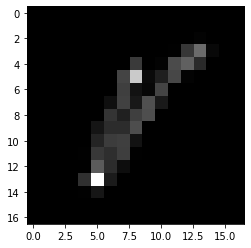

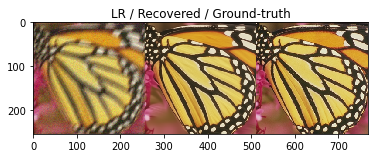

22-06-27 10:43:23.467 : ---1--> butterfly.png --k: 1 PSNR: 28.63dB


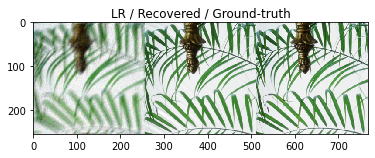

22-06-27 10:43:26.792 : ---2--> leaves.png --k: 1 PSNR: 29.07dB


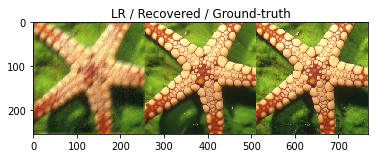

22-06-27 10:43:30.033 : ---3--> starfish.png --k: 1 PSNR: 29.30dB
22-06-27 10:43:30.035 : ------> Average PSNR of (set3c), kernel: (1) sigma: (1.30): 29.00 dB
22-06-27 10:43:30.044 : -------k: 2 ---------


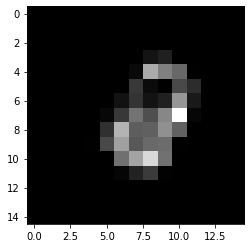

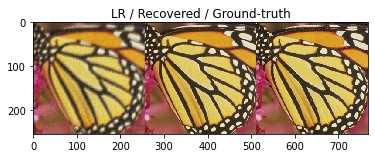

22-06-27 10:43:33.458 : ---1--> butterfly.png --k: 2 PSNR: 28.73dB


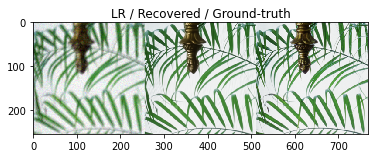

22-06-27 10:43:36.800 : ---2--> leaves.png --k: 2 PSNR: 29.41dB


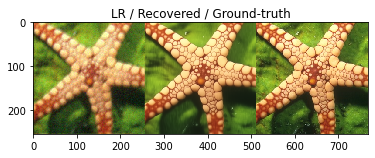

22-06-27 10:43:40.153 : ---3--> starfish.png --k: 2 PSNR: 29.10dB
22-06-27 10:43:40.156 : ------> Average PSNR of (set3c), kernel: (2) sigma: (1.30): 29.08 dB
22-06-27 10:43:40.164 : -------k: 3 ---------


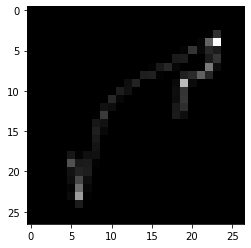

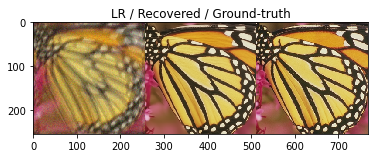

22-06-27 10:43:43.504 : ---1--> butterfly.png --k: 3 PSNR: 28.39dB


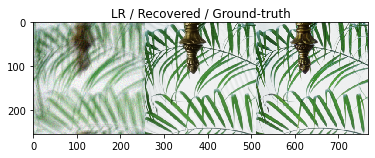

22-06-27 10:43:46.744 : ---2--> leaves.png --k: 3 PSNR: 28.70dB


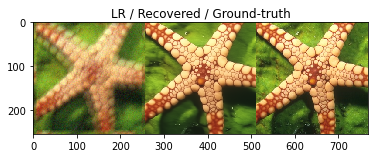

22-06-27 10:43:50.012 : ---3--> starfish.png --k: 3 PSNR: 28.98dB
22-06-27 10:43:50.014 : ------> Average PSNR of (set3c), kernel: (3) sigma: (1.30): 28.69 dB
22-06-27 10:43:50.025 : -------k: 4 ---------


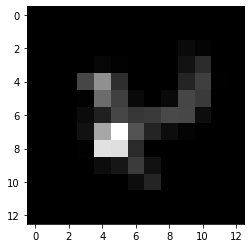

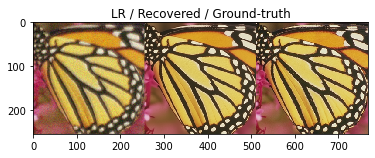

22-06-27 10:43:53.434 : ---1--> butterfly.png --k: 4 PSNR: 29.91dB


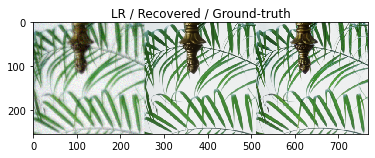

22-06-27 10:43:56.644 : ---2--> leaves.png --k: 4 PSNR: 31.07dB


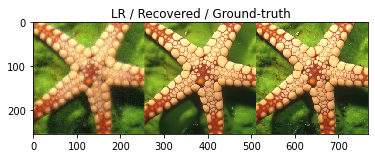

22-06-27 10:44:00.323 : ---3--> starfish.png --k: 4 PSNR: 30.16dB
22-06-27 10:44:00.325 : ------> Average PSNR of (set3c), kernel: (4) sigma: (1.30): 30.38 dB
22-06-27 10:44:00.344 : -------k: 5 ---------


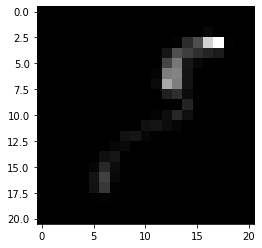

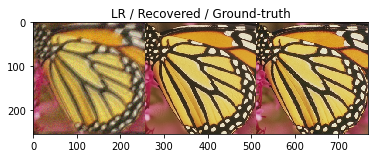

22-06-27 10:44:03.627 : ---1--> butterfly.png --k: 5 PSNR: 29.65dB


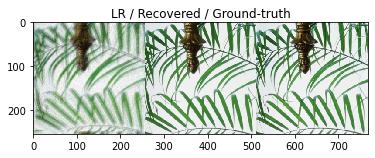

22-06-27 10:44:07.003 : ---2--> leaves.png --k: 5 PSNR: 30.49dB


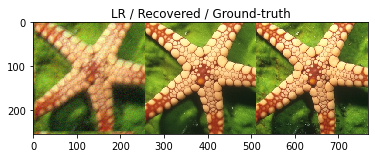

22-06-27 10:44:10.370 : ---3--> starfish.png --k: 5 PSNR: 29.60dB
22-06-27 10:44:10.374 : ------> Average PSNR of (set3c), kernel: (5) sigma: (1.30): 29.91 dB
22-06-27 10:44:10.391 : -------k: 6 ---------


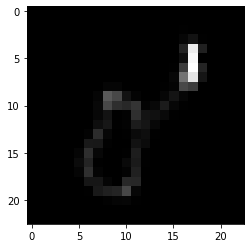

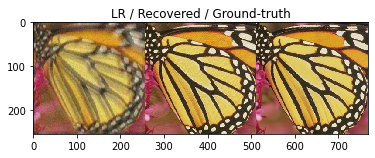

22-06-27 10:44:13.799 : ---1--> butterfly.png --k: 6 PSNR: 27.44dB


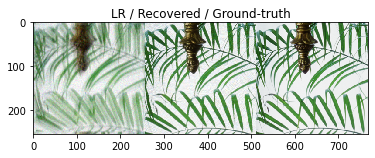

22-06-27 10:44:17.219 : ---2--> leaves.png --k: 6 PSNR: 27.91dB


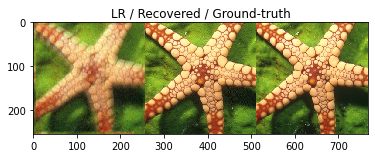

22-06-27 10:44:20.387 : ---3--> starfish.png --k: 6 PSNR: 27.66dB
22-06-27 10:44:20.388 : ------> Average PSNR of (set3c), kernel: (6) sigma: (1.30): 27.67 dB
22-06-27 10:44:20.401 : -------k: 7 ---------


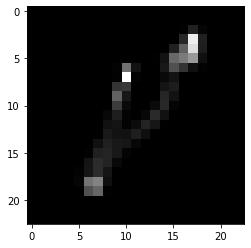

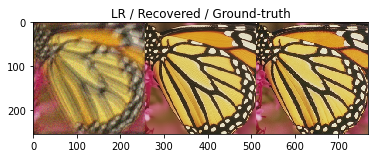

22-06-27 10:44:23.724 : ---1--> butterfly.png --k: 7 PSNR: 28.84dB


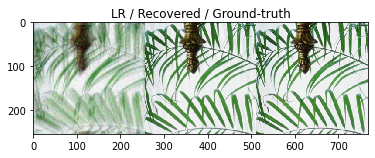

22-06-27 10:44:26.986 : ---2--> leaves.png --k: 7 PSNR: 28.99dB


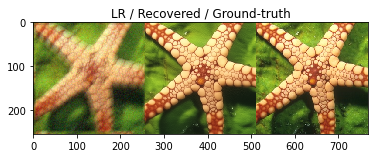

22-06-27 10:44:30.683 : ---3--> starfish.png --k: 7 PSNR: 29.13dB
22-06-27 10:44:30.686 : ------> Average PSNR of (set3c), kernel: (7) sigma: (1.30): 28.99 dB


Average of all kernels : 29.124745866758293 Lamda: 0.0075 Sigma2:  1.3


NameError: ignored

In [ ]:
dic[i] = iterate_hyper_params(_lam_ =0.0075, NLM = 1.3)